# Sentiment Analysis with BERT

In this notebook, we'll perform sentiment analysis using BERT (Bidirectional Encoder Representations from Transformers) on a Twitter sentiment dataset.

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)

## Load and Preprocess Data

In [48]:
df = pd.read_csv('/kaggle/input/tweets-sentiment-analysis/train_data.csv')

In [49]:
df.head()

,sentence,sentiment
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


<Axes: xlabel='sentiment', ylabel='count'>

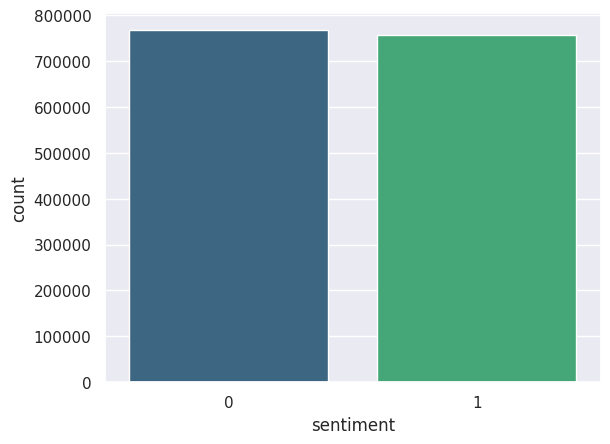

In [50]:
# Visualize the class distribution
sns.countplot(x='sentiment', data=df, palette='viridis')

In [52]:
# Preprocess the text data
# Define regular expressions for hashtags, mentions, and URLs
import re
hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")


In [ ]:
# Function to preprocess text
def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    text = mentions.sub(' entity', text)
    return text.strip().lower()

In [53]:
# Apply text preprocessing
df['sentence'] = df.sentence.apply(process_text)

In [55]:
df.head()

,sentence,sentiment
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


## Tokenization and DataLoader Preparation


In [56]:
# Extract labels and text
labels = df.sentiment.values
text = df.sentence.values

In [57]:
# Load BERT tokenizer
from transformers import BertTokenizer,BertForSequenceClassification,AdamW
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

In [59]:
# Tokenize text and prepare DataLoader
input_ids = []
attention_mask = []
for i in text:
    encoded_data = tokenizer.encode_plus(
        i,
        add_special_tokens=True,
        max_length=64,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_data['input_ids'])
    attention_mask.append(encoded_data['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_mask = torch.cat(attention_mask, dim=0)
labels = torch.tensor(labels)

In [60]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split

In [ ]:
# Create TensorDataset
dataset = TensorDataset(input_ids,attention_mask,labels)

In [61]:
# Split dataset into train and validation sets
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print('Training Size - ',train_size)
print('Validation Size - ',val_size)

Training Size -  1219180
Validation Size -  304795


In [62]:
# Create DataLoader
train_dl = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),
                     batch_size = 256)
val_dl = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),
                     batch_size = 256)

In [64]:
# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
'bert-base-uncased',
num_labels = 2,
output_attentions = False,
output_hidden_states = False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
import random
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [66]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [67]:
# Define optimizer 
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [68]:
# Define learning rate scheduler
from transformers import get_linear_schedule_with_warmup
epochs = 1
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [69]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [70]:
def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [71]:
from tqdm.notebook import tqdm
torch.cuda.empty_cache()

# Training loop
for epoch in tqdm(range(1, epochs+1)):
    # Set model to training mode
    model.train()
    # Initialize variables for tracking loss
    loss_train_total = 0
    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    # Iterate over training DataLoader
    for batch in progress_bar:
        # Zero gradients
        model.zero_grad()
        # Move batch to device
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
        # Forward pass
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    tqdm.write(f'\nEpoch {epoch}')
    # Compute average training loss
    loss_train_avg = loss_train_total/len(train_dl)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    # Evaluate on validation set
    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)
    # Save model if validation loss decreases
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/4763 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.359135666443299
Validation loss: 0.33621828005305865
Accuracy: 0.8528387932872915


## Save Model and Tokenizer

In [85]:
# Save model and tokenizer
output_dir = './'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

## Inference

In [89]:
# Function for sentiment prediction
def Sentiment(sent):
    output_dir = './'
    tokenizer = BertTokenizer.from_pretrained(output_dir)
    model_loaded = BertForSequenceClassification.from_pretrained(output_dir)
    # Tokenize input sentence
    encoded_dict = tokenizer.encode_plus(
                        sent, 
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    # Move tensors to device   
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    input_id = torch.LongTensor(input_id)
    attention_mask = torch.LongTensor(attention_mask)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_loaded = model_loaded.to(device)
    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)
    # Perform inference
    with torch.no_grad():
        outputs = model_loaded(input_id, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0]
    index = logits.argmax()
    return index

# Example usage


In [90]:
ans = Sentiment('i want you to die')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [91]:
if ans == 1:
    print("Positive")
else:
    print("Negative")

Negative


In [92]:
ans = Sentiment("it's really a nice , bad and cool tool")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [93]:
if ans == 1:
    print("Positive")
else:
    print("Negative")

Positive


In [94]:
# Save model as .pt file
model_save_path = 'bert_sentiment_model.pt'
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to bert_sentiment_model.pt


## Model Evaluation on Test Set

In [97]:
test_df = pd.read_csv('/kaggle/input/tweets-sentiment-analysis/test_data.csv', encoding='latin-1')
test_df.head()

,sentence,sentiment
0,i loooooooovvvvvveee my kindle not that the dx...,1
1,reading my kindle love it lee childs is good read,1
2,ok first assesment of the kindle it fucking rocks,1
3,you ll love your kindle i ve had mine for a fe...,1
4,fair enough but i have the kindle and i think ...,1


In [122]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
# Preprocess test data
test_df['sentence'] = test_df['sentence'].apply(process_text)

# Tokenize the text
input_ids = []
attention_mask = []
for text in test_df['sentence']:
    encoded_data = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=64,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_data['input_ids'])
    attention_mask.append(encoded_data['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_mask = torch.cat(attention_mask, dim=0)

# Create DataLoader
test_dataset = TensorDataset(input_ids, attention_mask)
test_dl = DataLoader(test_dataset, batch_size=32)

# Perform inference
predictions = []
for batch in test_dl:
    batch = tuple(b.to(device) for b in batch)
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs[0]
    predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())

In [123]:
# Evaluate the results
test_labels = test_df['sentiment'].values
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')


Accuracy: 0.8440111420612814
Precision: 0.8247422680412371
Recall: 0.8791208791208791
F1-score: 0.851063829787234
